In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import pandas as pd
from pandas import DataFrame,Series
from datetime import datetime,timedelta
from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR

In [14]:
def daterange(start_date, number_of_days):  # generate business days from a certain date
    start_date = datetime.strptime(start_date, "%Y-%m-%d") +timedelta(days = 1)
    end_date =  start_date+timedelta(days =  number_of_days)
    return [dt.date().strftime("%Y-%m-%d") for dt in rrule(DAILY, dtstart=start_date, until=end_date, byweekday=(MO,TU,WE,TH,FR))]

In [26]:
daterange(df['Date'].values[-1],14)

['2020-10-14',
 '2020-10-15',
 '2020-10-16',
 '2020-10-19',
 '2020-10-20',
 '2020-10-21',
 '2020-10-22',
 '2020-10-23',
 '2020-10-26',
 '2020-10-27',
 '2020-10-28']

## load the data and inspect them

In [2]:
df=pd.read_csv(r'C:\Users\sujun\Desktop\Python Codes\STAT 6289\HW3\TSLA.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1328, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-09,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


## Split the data into training and test sets

In [3]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

## Build the input features with different time lags (1 day)

In [4]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

## Build LSTM mode, decide how many neurons and how many layers, and design loss function and optimizer. 

In [61]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0780
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0178
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0136
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0123
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0108
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0116
Epoch 11/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0102
Epoch 12/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0099
Epoch 13/100
24/24 [==========

## Generate test data

In [62]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 588): #519 589
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Testing model

In [63]:
# For testing
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

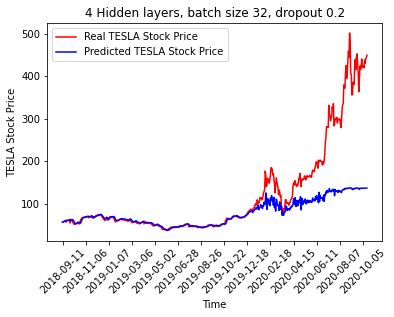

In [64]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,528,40),rotation=45)
plt.title('4 Hidden layers, batch size 32, dropout 0.2')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.savefig(r'C:\Users\sujun\Desktop\Python Codes\STAT 6289\HW3\4 Hidden layers, batch size 32, dropout 0.2.png',dpi=200, bbox_inches='tight')
plt.show()

## Prediction

In [65]:
# For prediction
import copy
predicted_days=14
X_test2=copy.deepcopy(X_test)
for i in range(predicted_days):
    X_temp=np.zeros([1,60,1])
    for j in range(58):
        X_temp[0][j][0]=X_test2[-1][j+1][0]
    X_temp[0][59][0]=model.predict(X_test2[-1:])[0][0]
    X_test2=np.vstack([X_test2,X_temp])
predicted_stock_price = model.predict(X_test2)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

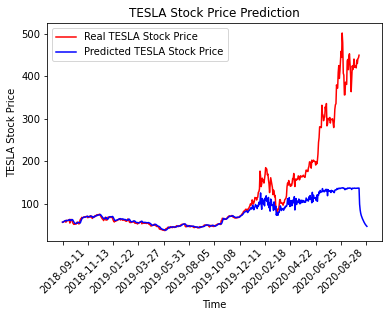

In [67]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.xticks(np.arange(0,543,45),rotation=45)
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.savefig(r'C:\Users\sujun\Desktop\Python Codes\STAT 6289\HW3\prediction.png',dpi=200, bbox_inches='tight')
plt.show()